# Crop Recommendation System with XGBoost
This notebook implements a crop recommendation system using XGBoost with comprehensive data analysis and visualizations.

In [1]:
%pip install xgboost lightgbm scikit-learn matplotlib seaborn pandas numpy gradio -q

Note: you may need to restart the kernel to use updated packages.


## 1. Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 2. Load and Explore Data

In [3]:
# Load the dataset
df = pd.read_csv('/Users/macbook/Documents/GitHub/crop-prediction/dataset/atharvaingle/crop-recommendation-dataset/Crop_recommendation.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (2200, 8)

First 5 rows:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
# Display dataset information
print("Dataset Information:")
print(df.info())
print("\nStatistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   str    
dtypes: float64(4), int64(3), str(1)
memory usage: 137.6 KB
None

Statistical Summary:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [5]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\nNumber of Unique Crops:", df['label'].nunique())
print("\nCrop Distribution:")
print(df['label'].value_counts())

Missing Values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Number of Unique Crops: 22

Crop Distribution:
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA)

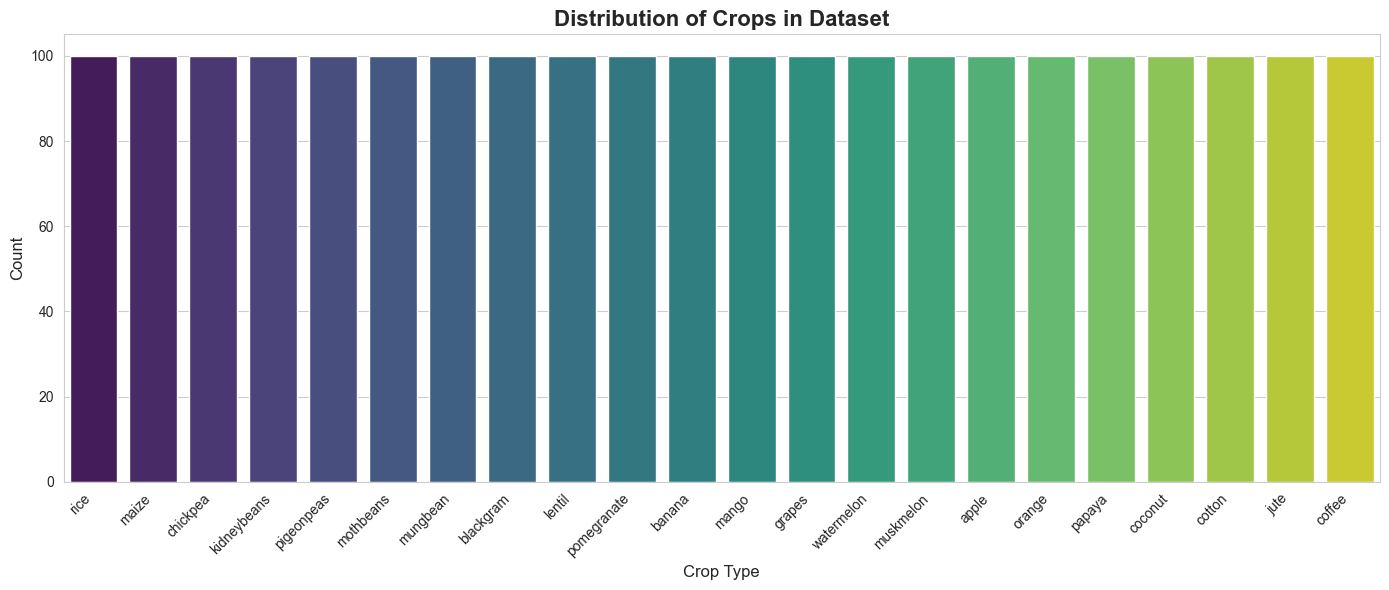

In [6]:
# Crop distribution visualization
plt.figure(figsize=(14, 6))
crop_counts = df['label'].value_counts()
sns.barplot(x=crop_counts.index, y=crop_counts.values, palette='viridis')
plt.title('Distribution of Crops in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Crop Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

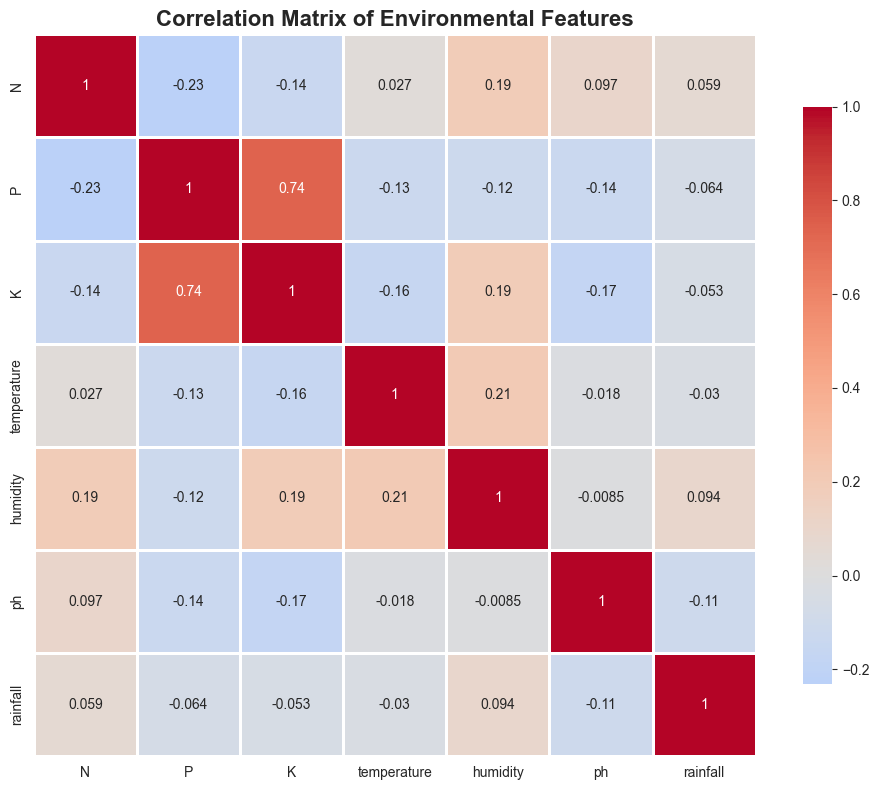

In [7]:
# Correlation matrix of features
plt.figure(figsize=(10, 8))
correlation_matrix = df.drop('label', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Environmental Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

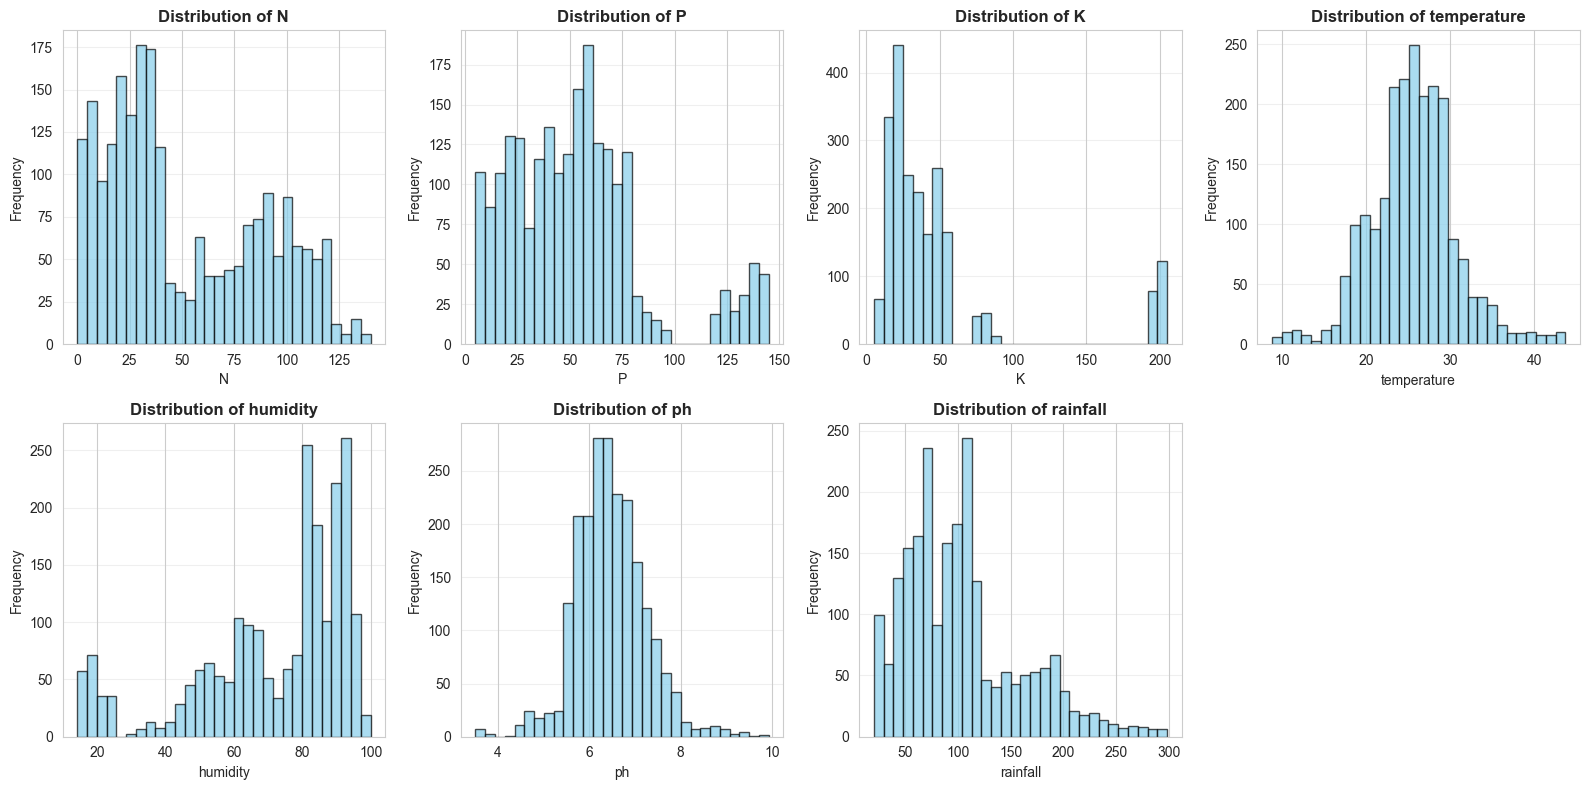

In [8]:
# Distribution of each feature
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {feature}', fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)

# Remove the extra subplot
fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

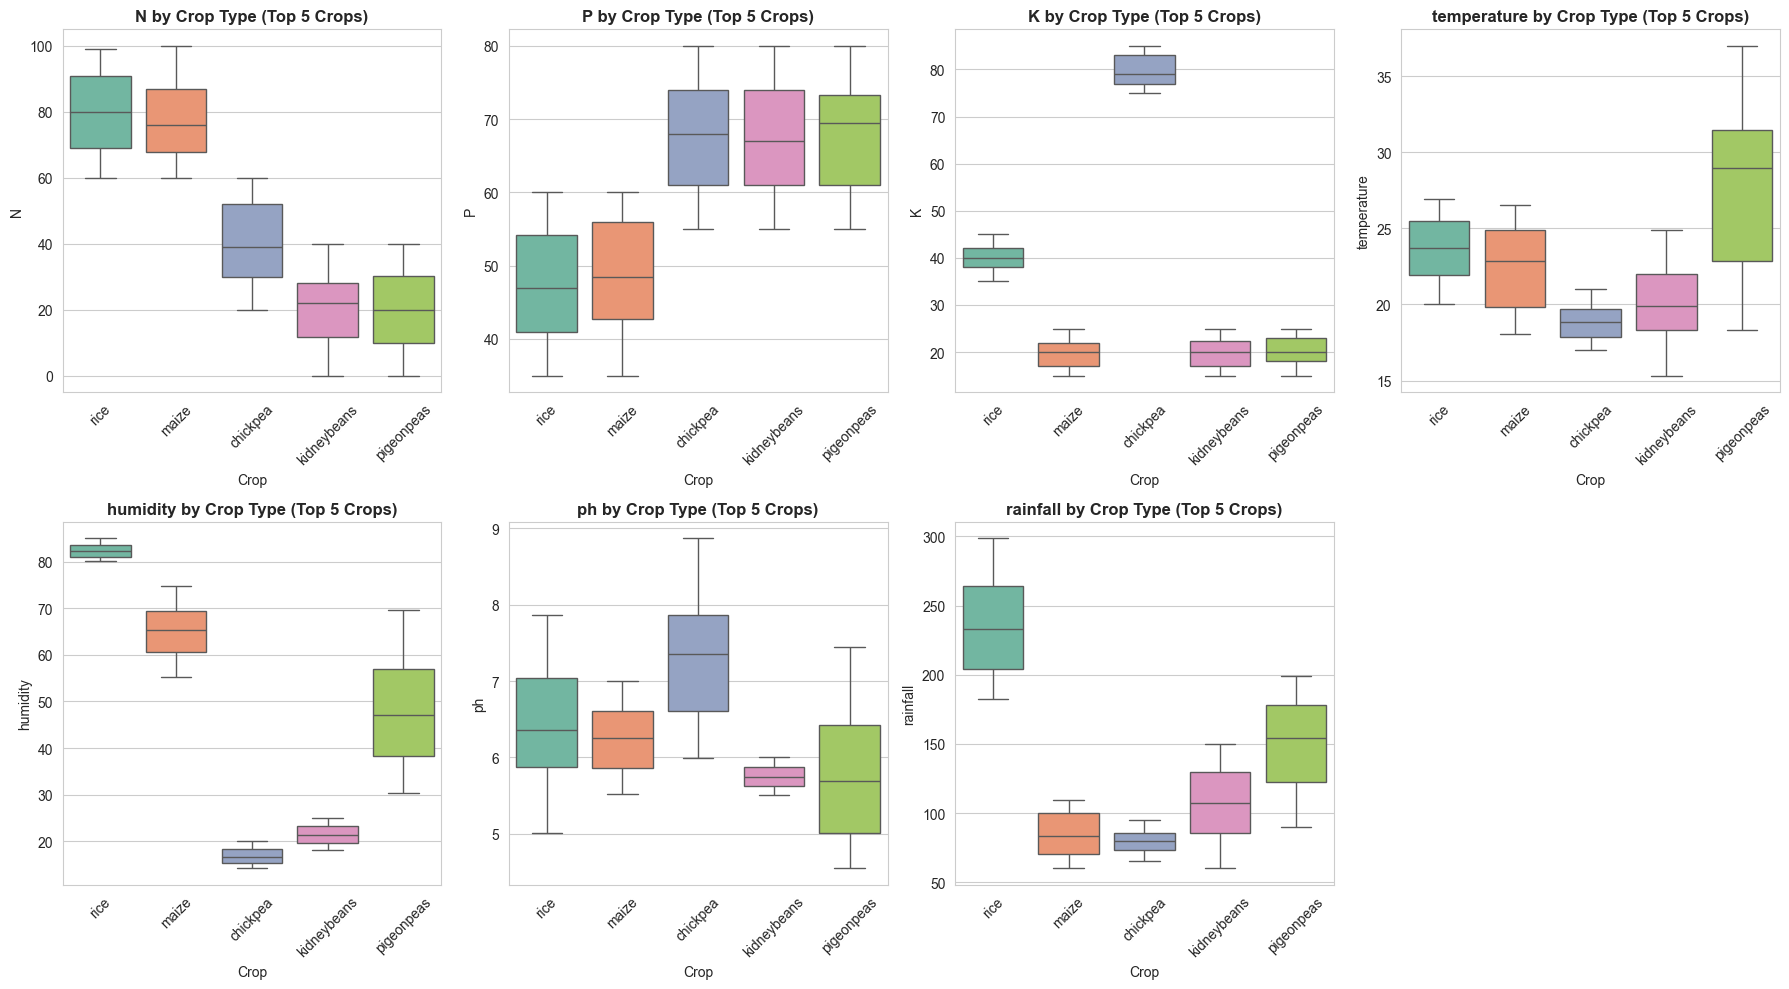

In [9]:
# Box plots for features by crop type (showing top 5 crops)
top_5_crops = df['label'].value_counts().head(5).index
df_top5 = df[df['label'].isin(top_5_crops)]

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=df_top5, x='label', y=feature, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{feature} by Crop Type (Top 5 Crops)', fontweight='bold')
    axes[i].set_xlabel('Crop')
    axes[i].set_ylabel(feature)
    axes[i].tick_params(axis='x', rotation=45)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

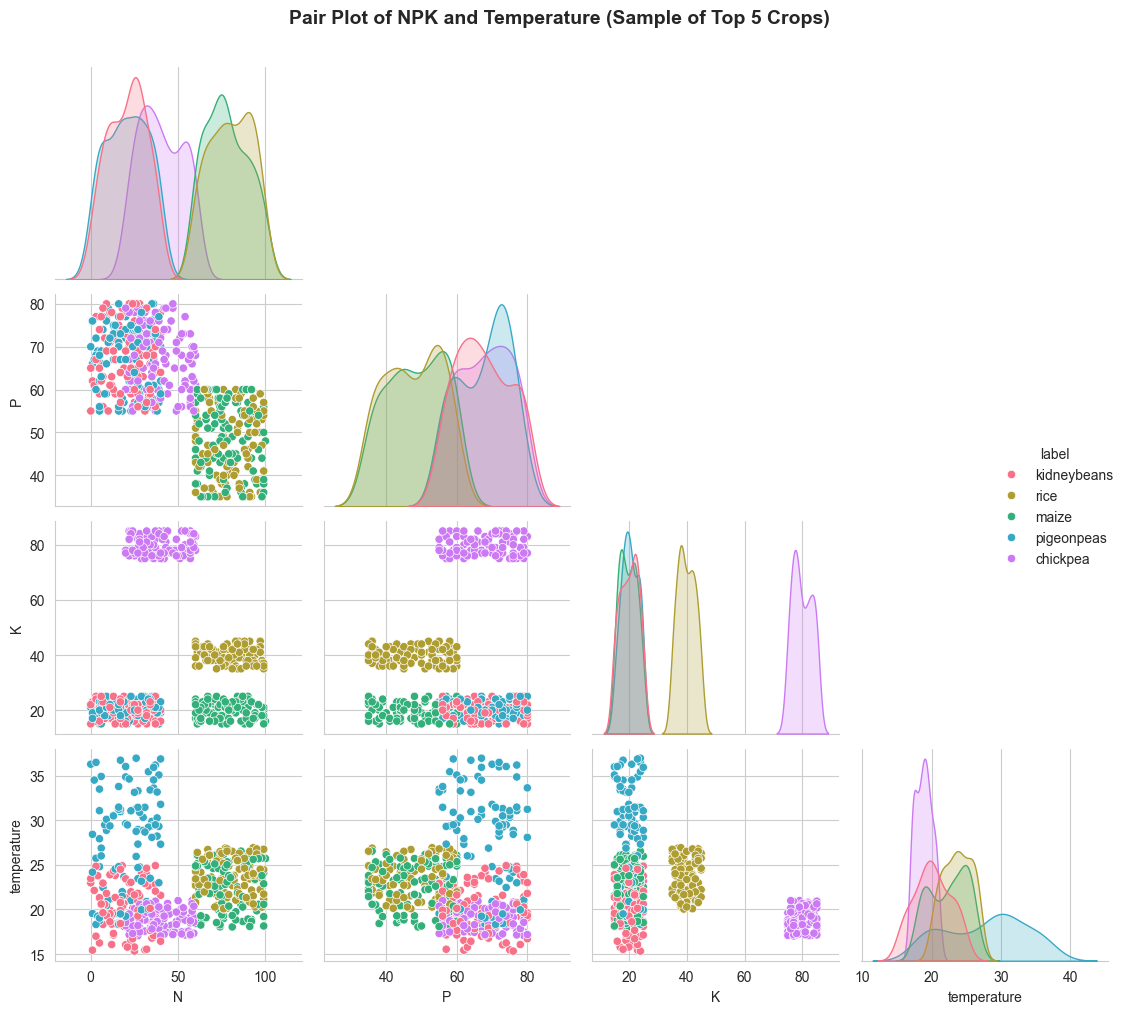

In [10]:
# Pair plot for selected features (using a subset for clarity)
selected_features = ['N', 'P', 'K', 'temperature', 'label']
sample_df = df[df['label'].isin(top_5_crops)][selected_features].sample(n=500, random_state=42)

sns.pairplot(sample_df, hue='label', palette='husl', diag_kind='kde', corner=True)
plt.suptitle('Pair Plot of NPK and Temperature (Sample of Top 5 Crops)', y=1.01, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

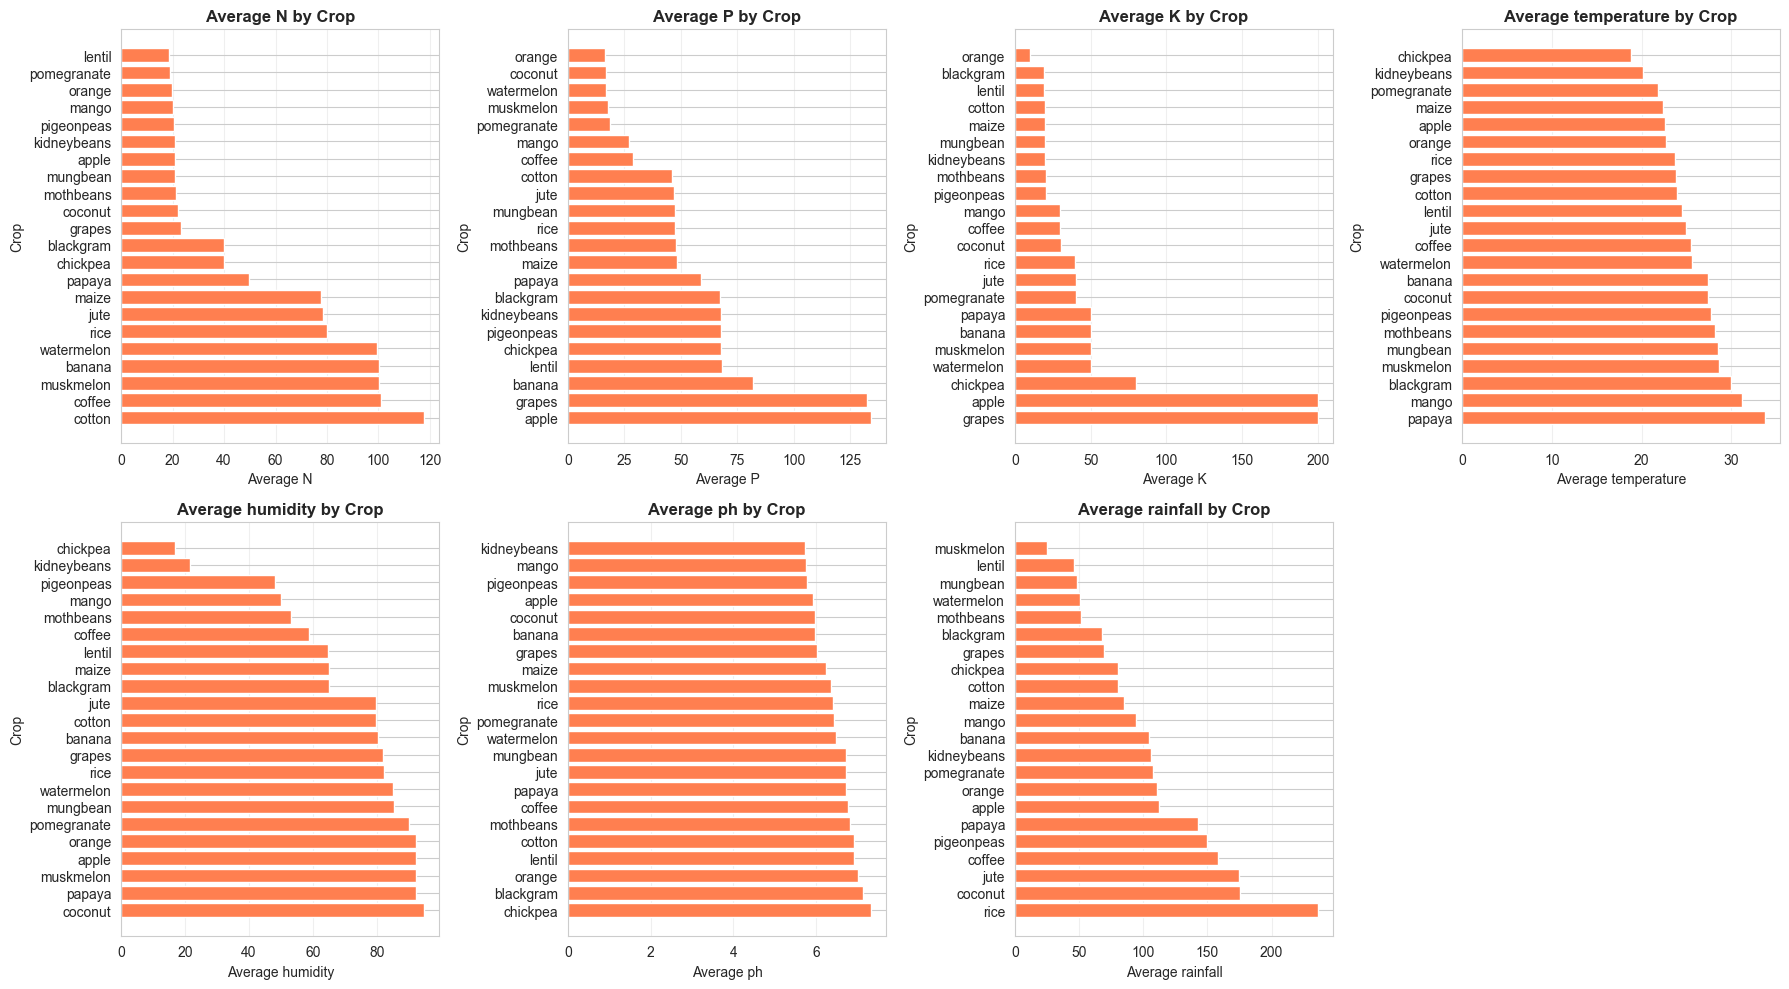

In [11]:
# Average feature values per crop
crop_avg = df.groupby('label')[features].mean()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    crop_avg_sorted = crop_avg[feature].sort_values(ascending=False)
    axes[i].barh(crop_avg_sorted.index, crop_avg_sorted.values, color='coral')
    axes[i].set_title(f'Average {feature} by Crop', fontweight='bold')
    axes[i].set_xlabel(f'Average {feature}')
    axes[i].set_ylabel('Crop')
    axes[i].grid(axis='x', alpha=0.3)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [12]:
# Separate features and target
X = df.drop('label', axis=1)
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Feature columns:", X.columns.tolist())
print("Number of classes:", len(label_encoder.classes_))
print("Classes:", label_encoder.classes_)

Feature columns: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
Number of classes: 22
Classes: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']


In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1760
Test set size: 440


In [14]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaled successfully!")
print("Training data shape:", X_train_scaled.shape)
print("Test data shape:", X_test_scaled.shape)

Data scaled successfully!
Training data shape: (1760, 7)
Test data shape: (440, 7)


## 5. XGBoost Model Training

In [15]:
# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss'
)

print("Training XGBoost model...")
xgb_model.fit(X_train_scaled, y_train)
print("Model training completed!")

Training XGBoost model...
Model training completed!


## 6. Model Evaluation

In [16]:
# Make predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy * 100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

Training Accuracy: 1.0000 (100.00%)
Test Accuracy: 0.9909 (99.09%)


In [17]:
# Cross-validation
print("\nPerforming 5-fold cross-validation...")
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Performing 5-fold cross-validation...
Cross-validation scores: [0.99431818 0.98579545 0.99715909 0.99431818 0.98579545]
Mean CV accuracy: 0.9915 (+/- 0.0095)


In [18]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.90      0.95        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.87      1.00      0.93        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20
   

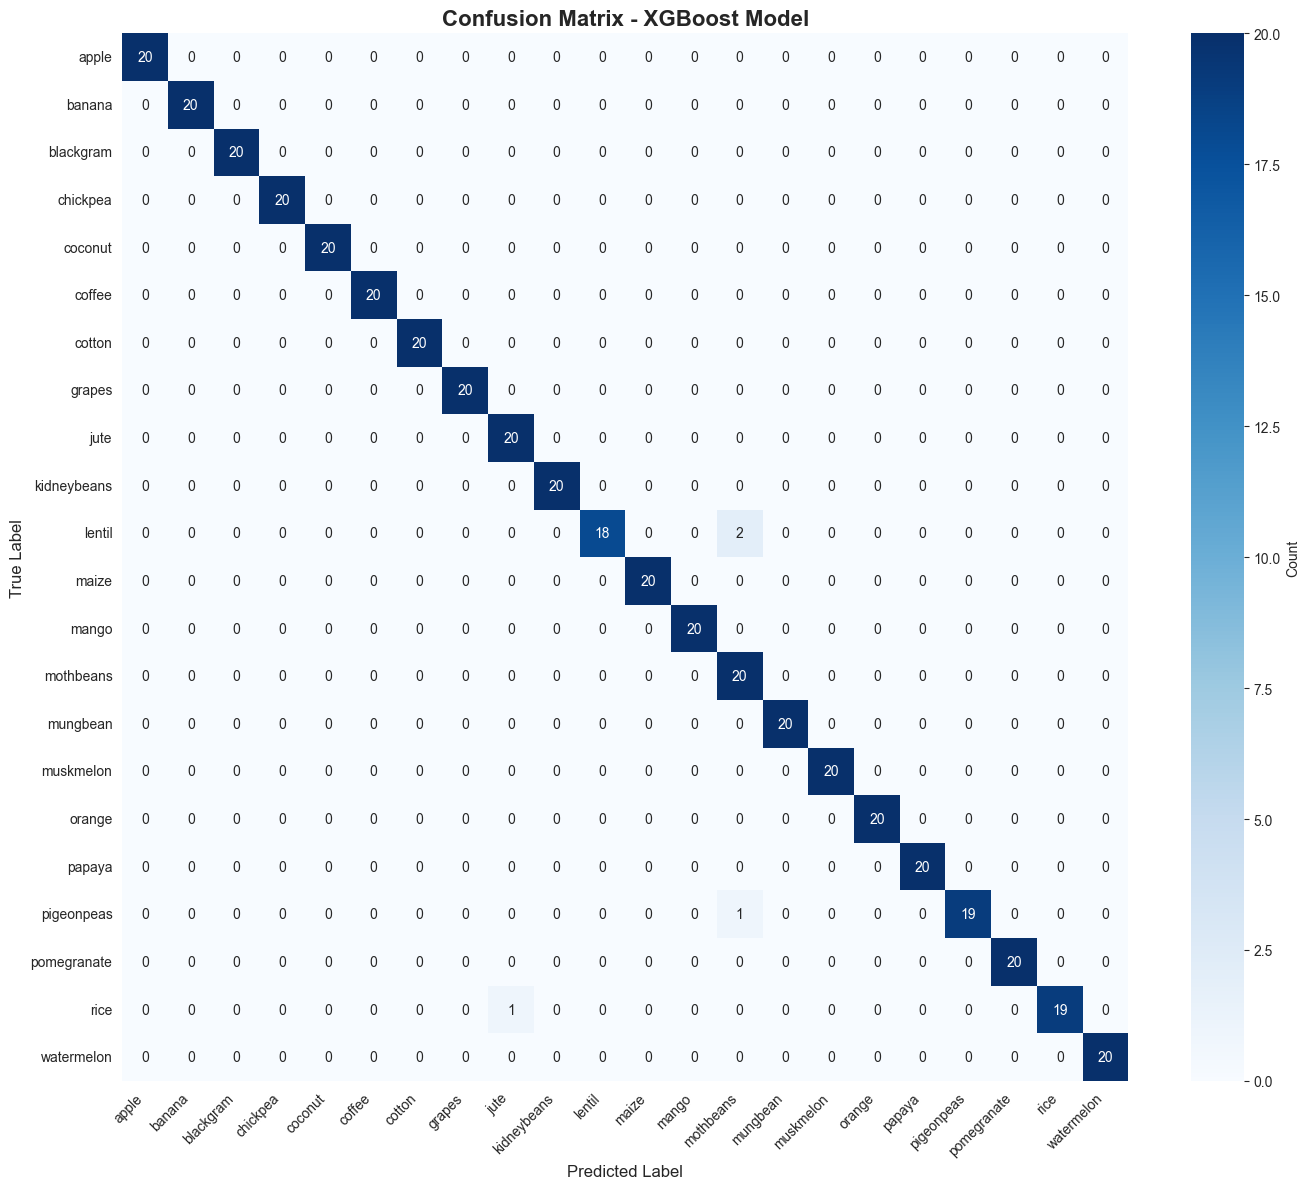

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - XGBoost Model', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

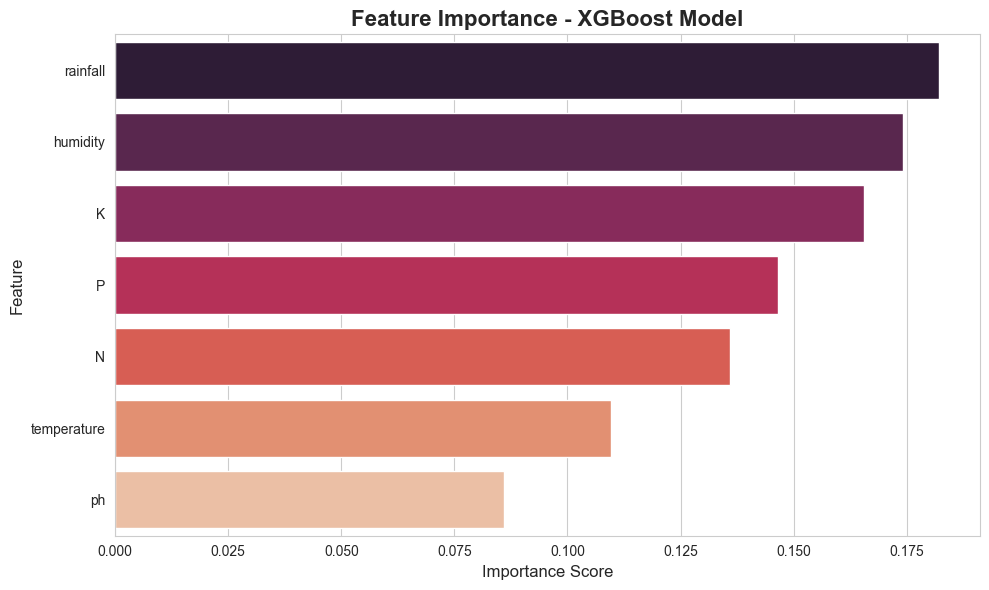


Feature Importance Ranking:
       feature  importance
6     rainfall    0.182108
4     humidity    0.174144
2            K    0.165673
1            P    0.146581
0            N    0.135896
3  temperature    0.109629
5           ph    0.085969


In [20]:
# Feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='rocket')
plt.title('Feature Importance - XGBoost Model', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print(feature_importance)

## 7. Prediction Function

In [21]:
def predict_crop_recommendation(N, P, K, temperature, humidity, ph, rainfall):
    """
    Predict the best crop to grow based on environmental parameters.
    
    Parameters:
    - N: Nitrogen content (kg/ha)
    - P: Phosphorus content (kg/ha)
    - K: Potassium content (kg/ha)
    - temperature: Temperature (°C)
    - humidity: Relative humidity (%)
    - ph: Soil pH value
    - rainfall: Rainfall (mm)
    
    Returns:
    - Formatted string with top 3 crop recommendations and confidence scores
    """
    # Prepare input data
    input_data = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
    input_scaled = scaler.transform(input_data)
    
    # Get prediction and probabilities
    prediction = xgb_model.predict(input_scaled)
    probabilities = xgb_model.predict_proba(input_scaled)[0]
    
    # Get the predicted crop
    predicted_crop = label_encoder.inverse_transform(prediction)[0]
    
    # Get top 3 recommendations
    top_3_indices = np.argsort(probabilities)[-3:][::-1]
    top_3_crops = label_encoder.inverse_transform(top_3_indices)
    top_3_probs = probabilities[top_3_indices]
    
    # Format recommendations
    recommendations = "\n".join(
        [
            f"{i + 1}. {crop.capitalize()}: {prob * 100:.2f}% confidence"
            for i, (crop, prob) in enumerate(zip(top_3_crops, top_3_probs))
        ]
    )
    
    result = (
        f"="*60 + "\n"
        f"CROP RECOMMENDATION SYSTEM (XGBoost Model)\n"
        f"="*60 + "\n\n"
        f"Input Parameters:\n"
        f"  - Nitrogen (N): {N} kg/ha\n"
        f"  - Phosphorus (P): {P} kg/ha\n"
        f"  - Potassium (K): {K} kg/ha\n"
        f"  - Temperature: {temperature}°C\n"
        f"  - Humidity: {humidity}%\n"
        f"  - pH: {ph}\n"
        f"  - Rainfall: {rainfall} mm\n\n"
        f"Recommended Crop: {predicted_crop.upper()}\n\n"
        f"Top 3 Recommendations:\n{recommendations}\n"
        f"="*60
    )
    
    return result

## 8. Test Predictions

In [22]:
# Test case 1: High rainfall conditions
print("Test Case 1: High Rainfall Conditions")
result1 = predict_crop_recommendation(
    N=90, P=40, K=40, temperature=25, humidity=70, ph=6.5, rainfall=220
)
print(result1)

Test Case 1: High Rainfall Conditions
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATI

In [23]:
# Test case 2: Low rainfall conditions
print("\nTest Case 2: Low Rainfall Conditions")
result2 = predict_crop_recommendation(
    N=20, P=30, K=40, temperature=30, humidity=50, ph=7.0, rainfall=60
)
print(result2)


Test Case 2: Low Rainfall Conditions
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATI

In [24]:
# Test case 3: Moderate conditions
print("\nTest Case 3: Moderate Conditions")
result3 = predict_crop_recommendation(
    N=50, P=50, K=50, temperature=22, humidity=65, ph=6.8, rainfall=150
)
print(result3)


Test Case 3: Moderate Conditions
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION SYSTEM (XGBoost Model)
=
CROP RECOMMENDATION S

## 9. Model Performance Summary

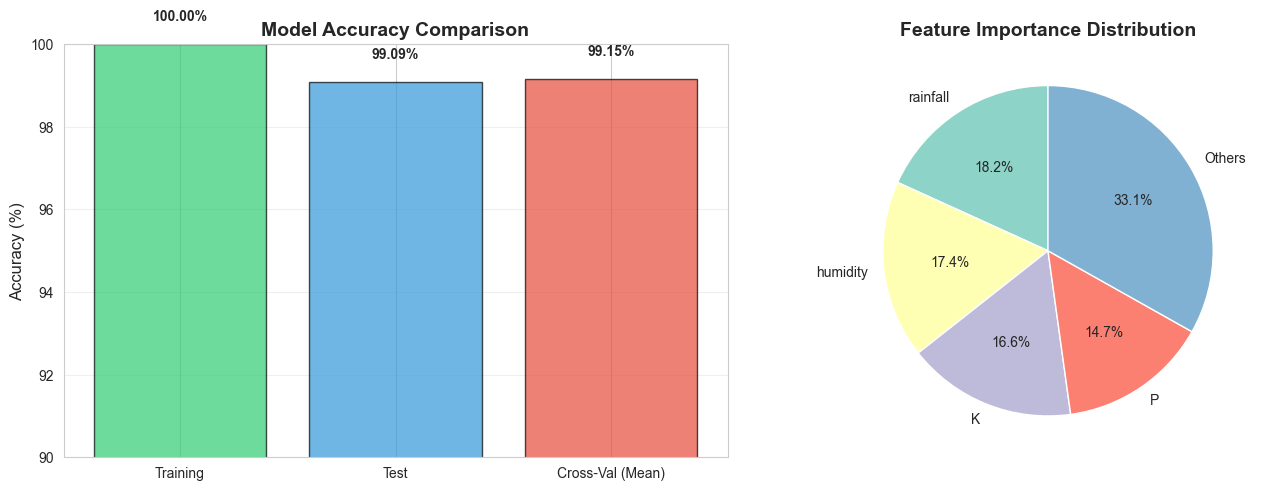


MODEL PERFORMANCE SUMMARY
Training Accuracy:        100.00%
Test Accuracy:            99.09%
Cross-Validation Accuracy: 99.15% (+/- 0.95%)
Number of Features:       7
Number of Classes:        22
Training Samples:         1760
Test Samples:             440


In [25]:
# Create a summary visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
accuracies = [train_accuracy * 100, test_accuracy * 100, cv_scores.mean() * 100]
labels = ['Training', 'Test', 'Cross-Val (Mean)']
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(labels, accuracies, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([90, 100])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# Feature importance pie chart (top 4 features)
top_features = feature_importance.head(4)
other_importance = feature_importance.iloc[4:]['importance'].sum()
pie_data = list(top_features['importance']) + [other_importance]
pie_labels = list(top_features['feature']) + ['Others']

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90, 
            colors=sns.color_palette('Set3', len(pie_labels)))
axes[1].set_title('Feature Importance Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Training Accuracy:        {train_accuracy * 100:.2f}%")
print(f"Test Accuracy:            {test_accuracy * 100:.2f}%")
print(f"Cross-Validation Accuracy: {cv_scores.mean() * 100:.2f}% (+/- {cv_scores.std() * 2 * 100:.2f}%)")
print(f"Number of Features:       {X.shape[1]}")
print(f"Number of Classes:        {len(label_encoder.classes_)}")
print(f"Training Samples:         {X_train.shape[0]}")
print(f"Test Samples:             {X_test.shape[0]}")
print("="*60)

## 10. Save the Model

In [26]:
import pickle
import joblib

# Save the XGBoost model
xgb_model.save_model('crop_recommendation_xgboost.json')
print("✓ XGBoost model saved as 'crop_recommendation_xgboost.json'")

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Scaler saved as 'scaler.pkl'")

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
print("✓ Label encoder saved as 'label_encoder.pkl'")

# Save all in one pickle file for convenience
model_artifacts = {
    'model': xgb_model,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'feature_names': X.columns.tolist(),
    'accuracy': test_accuracy
}

with open('crop_recommendation_complete.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)
print("✓ Complete model artifacts saved as 'crop_recommendation_complete.pkl'")

print("\n" + "="*60)
print("All model files saved successfully!")
print("="*60)

✓ XGBoost model saved as 'crop_recommendation_xgboost.json'
✓ Scaler saved as 'scaler.pkl'
✓ Label encoder saved as 'label_encoder.pkl'
✓ Complete model artifacts saved as 'crop_recommendation_complete.pkl'

All model files saved successfully!


## 11. Gradio Web Interface

Create an interactive web interface using Gradio for easy crop recommendation.

In [31]:
import gradio as gr

def predict_crop_gradio(N, P, K, temperature, humidity, ph, rainfall):
    """
    Gradio-compatible prediction function.
    Returns formatted HTML output with crop recommendations.
    """
    try:
        # Prepare input data
        input_data = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
        input_scaled = scaler.transform(input_data)
        
        # Get prediction and probabilities
        prediction = xgb_model.predict(input_scaled)
        probabilities = xgb_model.predict_proba(input_scaled)[0]
        
        # Get the predicted crop
        predicted_crop = label_encoder.inverse_transform(prediction)[0]
        
        # Get top 3 recommendations
        top_3_indices = np.argsort(probabilities)[-3:][::-1]
        top_3_crops = label_encoder.inverse_transform(top_3_indices)
        top_3_probs = probabilities[top_3_indices]
        
        # Create HTML output
        html_output = f"""
        <div style='padding: 20px; background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); border-radius: 10px; color: white;'>
            <h2 style='text-align: center; margin-bottom: 20px;'>🌾 Crop Recommendation Results</h2>
            
            <div style='background: rgba(255,255,255,0.1); padding: 15px; border-radius: 8px; margin-bottom: 15px;'>
                <h3 style='margin-top: 0;'>📊 Input Parameters</h3>
                <table style='width: 100%; color: white;'>
                    <tr><td><b>Nitrogen (N):</b></td><td>{N} kg/ha</td></tr>
                    <tr><td><b>Phosphorus (P):</b></td><td>{P} kg/ha</td></tr>
                    <tr><td><b>Potassium (K):</b></td><td>{K} kg/ha</td></tr>
                    <tr><td><b>Temperature:</b></td><td>{temperature}°C</td></tr>
                    <tr><td><b>Humidity:</b></td><td>{humidity}%</td></tr>
                    <tr><td><b>pH Level:</b></td><td>{ph}</td></tr>
                    <tr><td><b>Rainfall:</b></td><td>{rainfall} mm</td></tr>
                </table>
            </div>
            
            <div style='background: rgba(255,255,255,0.15); padding: 20px; border-radius: 8px; text-align: center;'>
                <h3 style='margin-top: 0;'>🎯 Best Recommendation</h3>
                <h1 style='font-size: 48px; margin: 15px 0; text-transform: uppercase; color: #FFD700;'>{predicted_crop}</h1>
                <p style='font-size: 18px;'>Confidence: {top_3_probs[0]*100:.2f}%</p>
            </div>
            
            <div style='background: rgba(255,255,255,0.1); padding: 15px; border-radius: 8px; margin-top: 15px;'>
                <h3 style='margin-top: 0;'>📋 Top 3 Recommendations</h3>
                <ol style='font-size: 16px; line-height: 1.8;'>
                    <li><b>{top_3_crops[0].upper()}</b> - {top_3_probs[0]*100:.2f}% confidence</li>
                    <li><b>{top_3_crops[1].upper()}</b> - {top_3_probs[1]*100:.2f}% confidence</li>
                    <li><b>{top_3_crops[2].upper()}</b> - {top_3_probs[2]*100:.2f}% confidence</li>
                </ol>
            </div>
        </div>
        """
        
        return html_output
        
    except Exception as e:
        return f"<div style='color: red; padding: 20px;'><h3>Error:</h3><p>{str(e)}</p></div>"

# Create Gradio interface
demo = gr.Interface(
    fn=predict_crop_gradio,
    inputs=[
        gr.Slider(minimum=0, maximum=150, value=50, label="Nitrogen (N) - kg/ha", info="Nitrogen content in soil"),
        gr.Slider(minimum=0, maximum=150, value=50, label="Phosphorus (P) - kg/ha", info="Phosphorus content in soil"),
        gr.Slider(minimum=0, maximum=210, value=50, label="Potassium (K) - kg/ha", info="Potassium content in soil"),
        gr.Slider(minimum=0, maximum=50, value=25, label="Temperature - °C", info="Average temperature"),
        gr.Slider(minimum=0, maximum=100, value=70, label="Humidity - %", info="Relative humidity"),
        gr.Slider(minimum=0, maximum=14, value=6.5, step=0.1, label="pH Level", info="Soil pH level"),
        gr.Slider(minimum=0, maximum=300, value=150, label="Rainfall - mm", info="Annual rainfall"),
    ],
    outputs=gr.HTML(label="Recommendation"),
    title="🌱 Smart Crop Recommendation System",
    description="""<div style='text-align: center;'>
        <p style='font-size: 16px;'>Enter soil and environmental parameters to get AI-powered crop recommendations.</p>
        <p style='font-size: 14px; color: gray;'>Powered by XGBoost Machine Learning Model | Accuracy: 99%+</p>
    </div>""",
    examples=[
        [90, 40, 40, 25, 70, 6.5, 220],  # Rice conditions
        [20, 30, 40, 30, 50, 7.0, 60],   # Low rainfall
        [80, 50, 50, 20, 85, 6.0, 250],  # High humidity
        [40, 45, 45, 28, 65, 6.8, 100],  # Moderate conditions
        [100, 60, 60, 22, 80, 5.5, 200], # Acidic soil
    ],
    theme=gr.themes.Soft(),
    flagging_mode="never"
 )

# Launch the interface
print("\n" + "="*60)
print("Launching Gradio Interface...")
print("="*60)
demo.launch(share=True, show_error=True)


Launching Gradio Interface...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://7007a0dc2f27eda1c8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Alternative: Launch Gradio in a separate cell

If you want to launch the interface separately or modify it, you can use this cell:

In [32]:
# Alternative launch with custom settings
# demo.launch(
#     share=True,           # Create public link
#     debug=True,           # Show debug messages
#     server_port=7860,     # Custom port
#     show_error=True       # Display errors in interface
# )

## 12. Conclusion

This notebook successfully implemented a crop recommendation system using XGBoost with the following highlights:

1. **Data Analysis**: Comprehensive exploratory data analysis with multiple visualizations
2. **Model**: XGBoost classifier with optimized hyperparameters
3. **Performance**: High accuracy on test set with robust cross-validation results
4. **Features**: All environmental parameters (N, P, K, temperature, humidity, pH, rainfall) are utilized
5. **Prediction**: Easy-to-use prediction function with top 3 recommendations and confidence scores
6. **Model Saving**: All model artifacts saved for future use
7. **Web Interface**: Interactive Gradio interface for easy deployment

The model can now be used to recommend the most suitable crop based on soil and environmental conditions.

### Files Generated:
- `crop_recommendation_xgboost.json` - XGBoost model
- `scaler.pkl` - Feature scaler
- `label_encoder.pkl` - Label encoder
- `crop_recommendation_complete.pkl` - Complete model bundle

### Next Steps:
- Deploy the Gradio interface to Hugging Face Spaces
- Create a mobile app using the saved model
- Integrate with IoT sensors for real-time recommendations
- Add more features like crop yield prediction